In [1]:
import sys
sys.path.append("../../")

from shared.sae_actions import load_pretrained_sae, sae_featurize_data 
from shared.models import MiniPileDataset
from shared.features import Feature, FeatureSample

%load_ext autoreload
%autoreload 2

/home/ubuntu/joe/predictive-saes/encoder_sae/venv/lib/python3.10/site-packages/pydantic/_internal/_config.py:341: UserWarning: Valid config keys have changed in V2:
* 'allow_mutation' has been removed
  warnings.warn(message, UserWarning)


In [2]:
# Load SAE
sae = load_pretrained_sae("../training_sae/saes/spam_messages_roberta_tied_weights_20241206_111202")

featurize train

In [3]:
import glob
import json
import os

def load_features(feature_dir):
    """Load features from JSON files and convert to Feature objects"""
    # Get all JSON files from the features directory
    feature_files = glob.glob(os.path.join(feature_dir, "*.json"))

    # Load all feature JSONs into Feature objects
    features = []
    for file in feature_files:
        with open(file) as f:
            feature_dict = json.load(f)
            
            # Convert samples to FeatureSample objects
            high_act_samples = [
                FeatureSample(text=s["text"], act=s["act"]) 
                for s in feature_dict["high_act_samples"]
            ]
            low_act_samples = [
                FeatureSample(text=s["text"], act=s["act"])
                for s in feature_dict["low_act_samples"] 
            ]
            
            feature = Feature(
                index=feature_dict["index"],
                label=feature_dict["label"],
                attributes=feature_dict["attributes"],
                reasoning=feature_dict["reasoning"],
                density=feature_dict["density"],
                confidence=feature_dict["confidence"],
                high_act_samples=high_act_samples,
                low_act_samples=low_act_samples
            )
            features.append(feature)

    # Sort features by index to maintain order
    features.sort(key=lambda x: x.index)

    # Extract labels and ids for easy reference
    autointerp_feature_labels = [f.label for f in features]
    autointerp_feature_ids = [f.index for f in features]

    return features, autointerp_feature_labels, autointerp_feature_ids

# Load features
feature_dir = "../feature_extraction/features/spam_messages_roberta_tied_weights"
features, autointerp_feature_labels, autointerp_feature_ids = load_features(feature_dir)


In [4]:
import pandas as pd
import numpy as np
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

def prepare_dataset(sentences_file, embeddings_file, sae, autointerp_feature_ids=None, feature_registry_file="feature_registry.npy", label_column='label', text_key="text", split_sentences=True):
    # Load dataset
    df = pd.read_csv(sentences_file)
    
    # Create MiniPileDataset
    mini_pile_dataset = MiniPileDataset(sentences_file, embeddings_file, key=text_key)
    
    # Featurize data
    try:
        X = np.memmap(
            feature_registry_file,
            dtype="float32",
            mode="r",
            shape=(sae.encoder.weight.shape[0], len(mini_pile_dataset.sentences)),
        )
    except FileNotFoundError:
        X = sae_featurize_data(mini_pile_dataset, sae, output_file=feature_registry_file)
    
    X = X.T
    
    # Apply num_features if specified
    if autointerp_feature_ids is not None:
        X = X[:, autointerp_feature_ids]
    
    y = np.where(df[label_column] == 'ham', 0, 1)
    
    if split_sentences:
        X_split = []
        y_split = []
        for i, text in enumerate(df[text_key]):
            sentences = sent_tokenize(text)
            X_split.extend([X[i]] * len(sentences))
            y_split.extend([y[i]] * len(sentences))
        X = np.array(X_split)
        y = np.array(y_split)
    
    return X, y

[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
sentences_file = "../data_preparation/data/spam_messages_train.csv"
embeddings_file = "../data_preparation/embedding_chunks/embedded_chunks/spam_train_item_20241206_215253/embeddings.npy"
X_train, y_train = prepare_dataset(sentences_file, embeddings_file, sae, autointerp_feature_ids=autointerp_feature_ids, feature_registry_file="feature_registry_train_all.npy", split_sentences=False)

In [30]:
sentences_file = "../data_preparation/data/spam_messages_val.csv"
embeddings_file = "../data_preparation/embedding_chunks/embedded_chunks/spam_valid_20241206_095537/embeddings.npy"
X_val, y_val = prepare_dataset(sentences_file, embeddings_file, sae, autointerp_feature_ids=autointerp_feature_ids, feature_registry_file="feature_registry_val_all.npy")

Featurizing data:   0%|          | 0/5923 [00:00<?, ?it/s]

In [10]:
sentences_file = "../data_preparation/data/spam_messages_test.csv"
embeddings_file = "../data_preparation/embedding_chunks/embedded_chunks/spam_test_item_20241206_220900/embeddings.npy"
X_test, y_test = prepare_dataset(sentences_file, embeddings_file, sae, autointerp_feature_ids=autointerp_feature_ids, feature_registry_file="feature_registry_test_all.npy", split_sentences=False)

Featurizing data:   0%|          | 0/5926 [00:00<?, ?it/s]

## decision tree intervention

In [8]:
from itertools import combinations


class FeatureMixer:
  def __init__(self, feature_group):
    self.feature_group = feature_group

  def grid(self, k_features_per_combo: int =2):
    """Perform a grid search over all possible combinations of features"""

    # Get all possible combinations of features
    return list(combinations(self.feature_group, k_features_per_combo))

In [43]:
from sklearn import tree
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, accuracy_score, f1_score
import numpy as np
import tqdm
import concurrent.futures

# Grid search may take a while, you can curate the feature list to speed this process up significantly
def train_tree(train_x, train_y, test_x, test_y, depth):
  # train_x, test_x, train_y, test_y = train_test_split(x, y, train_size=0.5, random_state=42)

  # Create a nice regularized tree
  model = tree.DecisionTreeClassifier(
      max_depth=depth,
      min_samples_leaf=len(train_x) // 20,
      random_state=42
  )

  model.fit(train_x, train_y)

  pred = model.predict(test_x)

  # Calculate the f1 score of the model
  accuracy = balanced_accuracy_score(test_y, pred)
  score = f1_score(test_y, pred)

  return model, pred, score, accuracy


def find_best_combos(features, k_features_per_combo=2, top_n=10):
  combos = FeatureMixer(features).grid(k_features_per_combo=k_features_per_combo)
  top_combos = []

  MAX_WORKERS = 8

  futures_list = []

  with concurrent.futures.ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
    for combo in combos:
      def _test_combo(combo):
        def _select_feature_acts(combo, row):
          output = []
          for index, feature in enumerate(combo):
            for feature_act in row:
              if feature_act.feature.index == feature.index:
                output.append(feature_act.activation)
                break

          return output

        model, pred, score, accuracy = train_tree(X_train, y_train, X_test, y_test, depth=len(combo))

        return model, pred, score, accuracy, combo

      futures_list.append(executor.submit(_test_combo, combo))

    for future in tqdm.tqdm(futures_list):
      model, pred, score, accuracy, combo = future.result()
      split_value = model.tree_.threshold[0].copy()
      # Store the top N combinations based on score
      if len(top_combos) < top_n:
        top_combos.append((combo, score, model, accuracy, split_value))
        top_combos.sort(key=lambda x: x[1], reverse=True)
      elif score > top_combos[-1][1]:
        top_combos[-1] = (combo, score, model, accuracy, split_value)
        top_combos.sort(key=lambda x: x[1], reverse=True)

  return top_combos


best_combos_at_k = {}
main_results = []
for i in range(1):
  top_combos = find_best_combos(features, k_features_per_combo=i + 1, top_n=10)
  for rank, (combo, score, model, accuracy, split_value) in enumerate(top_combos, start=1):
    result = {
      "rank": rank,
      "features_count": i + 1,
      "combo": [feature.index for feature in combo],
      "score": score,
      "accuracy": accuracy,
      "split_values": split_value
    }
    main_results.append(result)

  best_combos_at_k[i + 1] = top_combos


100%|██████████| 200/200 [00:15<00:00, 12.85it/s]


In [44]:
best_combo_at_k[2][0]

(Feature(index=55, label='Promotional and marketing content', attributes='promotional offers, marketing messages, action-oriented language, urgency, exclusivity, financial incentives', reasoning="The samples contain various promotional offers, advertising schemes, solicitation of purchases, and marketing messages, often impersonally directing the reader to take some action, such as making a purchase or claiming a prize. These samples often contain urgency or exclusivity, with phrases like 'limited time offer,' 'hurry now,' and 'special offer.' They frequently involve monetary exchanges, discounts, deals, or reminders of subscription services. None of the samples discussed general personal or corporate email exchanges or informational content without a direct purchase or subscription message.", density=0.1981573803572833, confidence=80.0, high_act_samples=[FeatureSample(text='rituwears brings rakhi special offers flat 50 off on home section and many apparels dinner set 28 pcs rs 999/ on

In [15]:
best_combo_at_k

{1: (None, 0, None)}

In [16]:
# Function to visualize the decision tree
def visualize_tree(tree_model, features, class_names=['negative', 'positive']):
    import graphviz
    dot_data = tree.export_graphviz(
        tree_model, 
        out_file=None, 
        feature_names=[feature.label for feature in features],
        class_names=class_names,
        filled=True,
        rounded=True,
        special_characters=True
    )
    graph = graphviz.Source(dot_data)
    return graph

In [21]:
# Anyways let's look at the best overall tree
BEST_TREE_INDEX = 1
best_features = best_combo_at_k[BEST_TREE_INDEX][0]
best_score = best_combo_at_k[BEST_TREE_INDEX][1]
best_tree = best_combo_at_k[BEST_TREE_INDEX][2]

# Visualize the tree
print(best_tree)
print(best_features)
print(best_score)
visualize_tree(best_tree, best_features)

DecisionTreeClassifier(max_depth=1, min_samples_leaf=2369, random_state=42)
(Feature(index=55, label='Promotional and marketing content', attributes='promotional offers, marketing messages, action-oriented language, urgency, exclusivity, financial incentives', reasoning="The samples contain various promotional offers, advertising schemes, solicitation of purchases, and marketing messages, often impersonally directing the reader to take some action, such as making a purchase or claiming a prize. These samples often contain urgency or exclusivity, with phrases like 'limited time offer,' 'hurry now,' and 'special offer.' They frequently involve monetary exchanges, discounts, deals, or reminders of subscription services. None of the samples discussed general personal or corporate email exchanges or informational content without a direct purchase or subscription message.", density=0.1981573803572833, confidence=80.0, high_act_samples=[FeatureSample(text='rituwears brings rakhi special offer

ValueError: Length of feature_names, 1 does not match number of features, 200

## random forest

In [50]:
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

boruta_selector = BorutaPy(
  RandomForestClassifier(n_jobs=-1, class_weight="balanced", max_depth=5),
  n_estimators="auto",
  verbose=0,
  random_state=1,
)
boruta_selector.fit(X_train, y_train)

In [35]:
boruta_selector.n_features_

200

In [36]:
boruta_selector.ranking_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

In [22]:
features_folder = "../feature_extraction/features/spam_messages_roberta_tied_weights"

def get_feature_labels_from_mask(mask):
    import json
    import os
    from tabulate import tabulate
    
    feature_info = []
    for i, is_selected in enumerate(mask):
        if is_selected:
            feature_file = os.path.join(features_folder, f"feature_{i}.json")
            with open(feature_file) as f:
                feature_data = json.load(f)
                feature_info.append({
                    'index': i,
                    'label': feature_data['label'],
                    'confidence': feature_data.get('confidence', 'N/A')
                })
    
    # Print nicely formatted table
    headers = ['Index', 'Label', 'Confidence']
    table = [[info['index'], info['label'], info['confidence']] for info in feature_info]
    print(tabulate(table, headers=headers, tablefmt='grid'))
    
    return [info['label'] for info in feature_info]


In [23]:
print("\nSelected Features:")
get_feature_labels_from_mask(boruta_selector.support_weak_)


Selected Features:
+---------+----------------------------------------------+--------------+
|   Index | Label                                        |   Confidence |
+=========+==============================================+==============+
|       4 | Contains contact information                 |           80 |
+---------+----------------------------------------------+--------------+
|      20 | Spam or promotional indication               |           26 |
+---------+----------------------------------------------+--------------+
|      21 | Fragmented, urgent, obfuscated text patterns |            6 |
+---------+----------------------------------------------+--------------+
|      39 | Text with special patterns and symbols       |           75 |
+---------+----------------------------------------------+--------------+
|      97 | Contains direct call to action               |           30 |
+---------+----------------------------------------------+--------------+
|     121 | Spam-l

['Contains contact information',
 'Spam or promotional indication',
 'Fragmented, urgent, obfuscated text patterns',
 'Text with special patterns and symbols',
 'Contains direct call to action',
 'Spam-like and promotional structure',
 'Financial gain discussion',
 'Repetitive text sequences',
 'Promotional or sensitive content presence',
 'Structured financial and web content']

ok let's actually train it and evaluate it

In [24]:
from classifier_model import BinaryClassifierModel

# Initialize model
model = BinaryClassifierModel()

# Train model
model.train_model(
    X_train=X_train, 
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    use_feature_selection=False
)

# Evaluate model
model.evaluate_model(X_test, y_test)

Scaling features...
Will try 5 different max_depths and 3 different n_estimators
Total combinations to try: 15


Training Progress:   0%|          | 0/15 [00:00<?, ?it/s]


Iteration Results (max_depth=10, n_estimators=10):
Accuracy: 0.6544
Precision: 0.9940
Recall: 0.2747
F1: 0.4304
AUC-ROC: 0.7318

Iteration Results (max_depth=10, n_estimators=50):
Accuracy: 0.6546
Precision: 0.9909
Recall: 0.2760
F1: 0.4317
AUC-ROC: 0.7341

Iteration Results (max_depth=10, n_estimators=100):
Accuracy: 0.6560
Precision: 0.9923
Recall: 0.2785
F1: 0.4349
AUC-ROC: 0.7347

Iteration Results (max_depth=20, n_estimators=10):
Accuracy: 0.6584
Precision: 0.9925
Recall: 0.2835
F1: 0.4410
AUC-ROC: 0.7327

Iteration Results (max_depth=20, n_estimators=50):
Accuracy: 0.6569
Precision: 0.9926
Recall: 0.2802
F1: 0.4370
AUC-ROC: 0.7350

Iteration Results (max_depth=20, n_estimators=100):
Accuracy: 0.6570
Precision: 0.9924
Recall: 0.2805
F1: 0.4374
AUC-ROC: 0.7374

Iteration Results (max_depth=30, n_estimators=10):
Accuracy: 0.6563
Precision: 0.9793
Recall: 0.2828
F1: 0.4389
AUC-ROC: 0.7318

Iteration Results (max_depth=30, n_estimators=50):
Accuracy: 0.6552
Precision: 0.9721
Recall: 

## logistic regression model

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

# Initialize scaler and model
scaler = MinMaxScaler(feature_range=(0, 1))
model = LogisticRegression(max_iter=1000)

# Scale the features
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Train model
model.fit(X_train_scaled, y_train)

# Get predictions on validation set
y_pred_val = model.predict(X_val_scaled)
y_pred_proba_val = model.predict_proba(X_val_scaled)[:, 1]

# Calculate validation metrics
print("\nValidation Metrics:")
print(f"Accuracy: {accuracy_score(y_val, y_pred_val):.4f}")
print(f"Precision: {precision_score(y_val, y_pred_val):.4f}")
print(f"Recall: {recall_score(y_val, y_pred_val):.4f}")
print(f"F1: {f1_score(y_val, y_pred_val):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_val, y_pred_proba_val):.4f}")

# Get predictions on test set
y_pred_test = model.predict(X_test_scaled)
y_pred_proba_test = model.predict_proba(X_test_scaled)[:, 1]

# Calculate test metrics
print("\nTest Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_test):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_test):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_test):.4f}")
print(f"F1: {f1_score(y_test, y_pred_test):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba_test):.4f}")

# Print feature indexes with the highest weights and their labels
feature_weights = model.coef_[0]
top_feature_indices = np.argsort(np.abs(feature_weights))[::-1][:10]  # Get top 10 feature indices
print("\nTop 10 Features with Highest Weights:")

# Create boolean mask for get_feature_labels_from_mask
mask = np.zeros(len(feature_weights), dtype=bool)
mask[top_feature_indices] = True

# Get labels and print table with weights
feature_labels = get_feature_labels_from_mask(mask)
for idx, label in zip(top_feature_indices, feature_labels):
    print(f"Feature {idx} ({label}): weight = {feature_weights[idx]:.4f}")



Validation Metrics:
Accuracy: 0.6817
Precision: 0.9637
Recall: 0.2387
F1: 0.3826
AUC-ROC: 0.6811

Test Metrics:
Accuracy: 0.6944
Precision: 0.9498
Recall: 0.2355
F1: 0.3774
AUC-ROC: 0.6744

Top 10 Features with Highest Weights:
+---------+----------------------------------------------+--------------+
|   Index | Label                                        |   Confidence |
+=========+==============================================+==============+
|      60 | Business and finance communication in Polish |           79 |
+---------+----------------------------------------------+--------------+
|      68 | Business and operational references          |           16 |
+---------+----------------------------------------------+--------------+
|      71 | Incomplete URL presence                      |           79 |
+---------+----------------------------------------------+--------------+
|      81 | Mentions Vikings and sports content          |           80 |
+---------+--------------------

## feature distribution visualizations

In [48]:
import matplotlib.pyplot as plt
import numpy as np

def plot_feature_distribution(X_test, y_test, idx, feature_name, split_value, bins=100):
    # Separate the feature values by class
    ham_values = X_test[y_test == 0, idx]
    spam_values = X_test[y_test == 1, idx]
    
    # Create histogram with specified x-axis range
    plt.figure(figsize=(10, 6))
    plt.hist(ham_values, bins=bins, alpha=0.5, label='Ham', density=False, range=(0.000, 4))
    plt.hist(spam_values, bins=bins, alpha=0.4, label='Spam', density=False, range=(0.000, 4))
    
    # Plot the split value as a dotted red line
    # plt.axvline(x=split_value, color='red', linestyle='--', label='Split Value')
    
    plt.xlabel(f'Activation Value')
    plt.ylabel('Count')
    plt.title(f'Feature: {feature_name}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

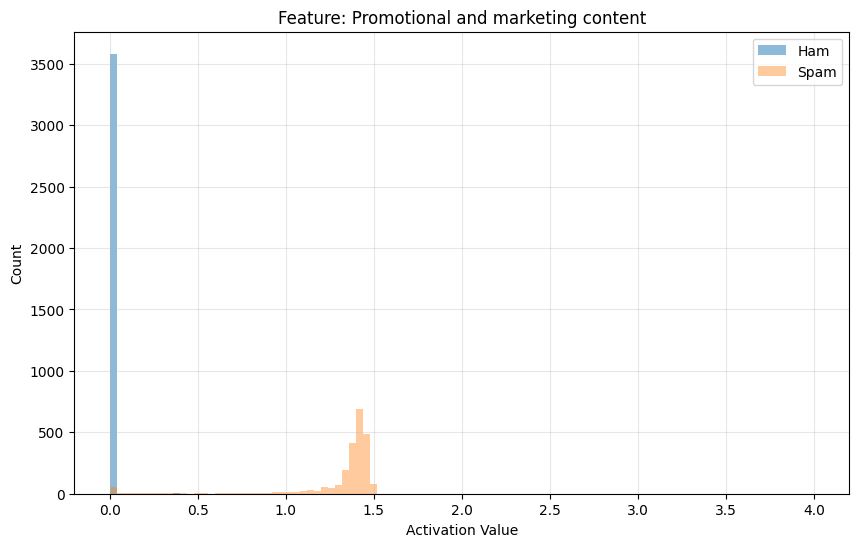

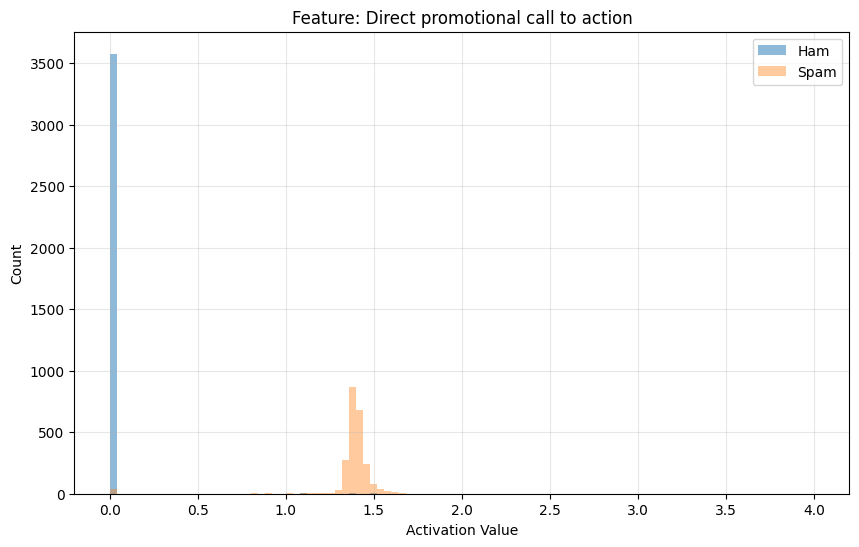

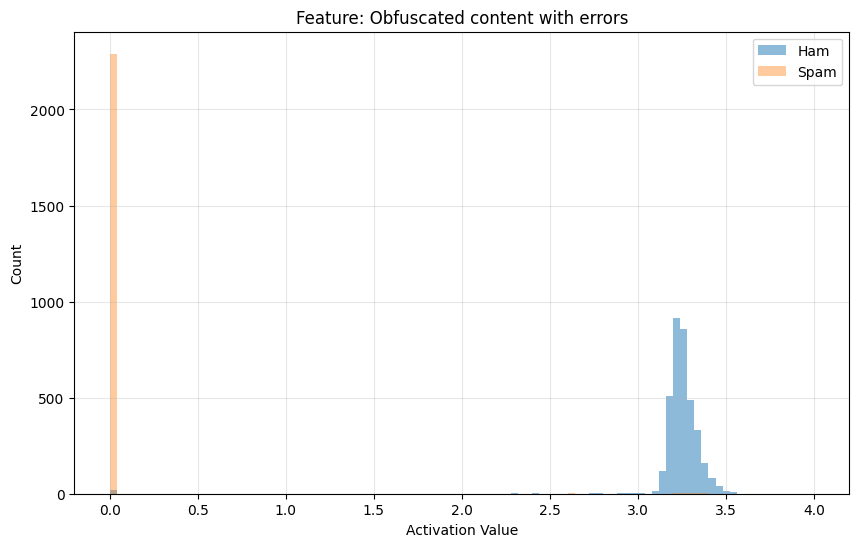

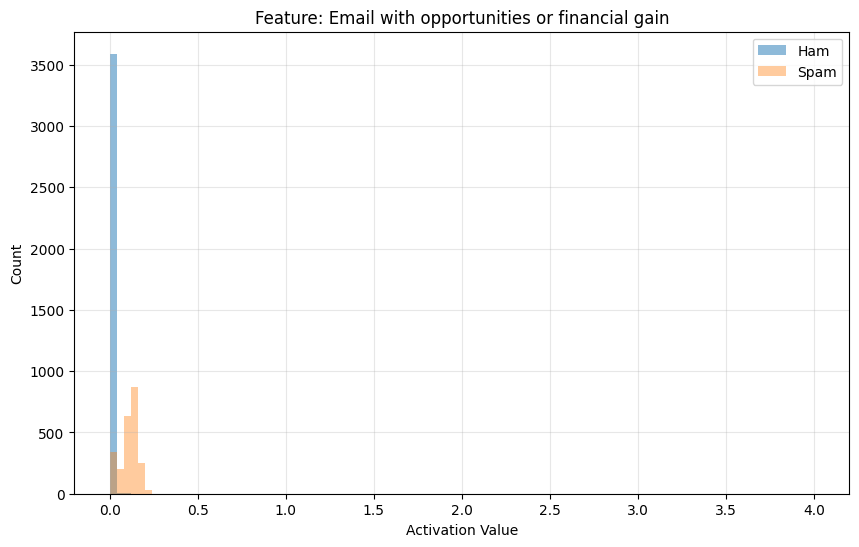

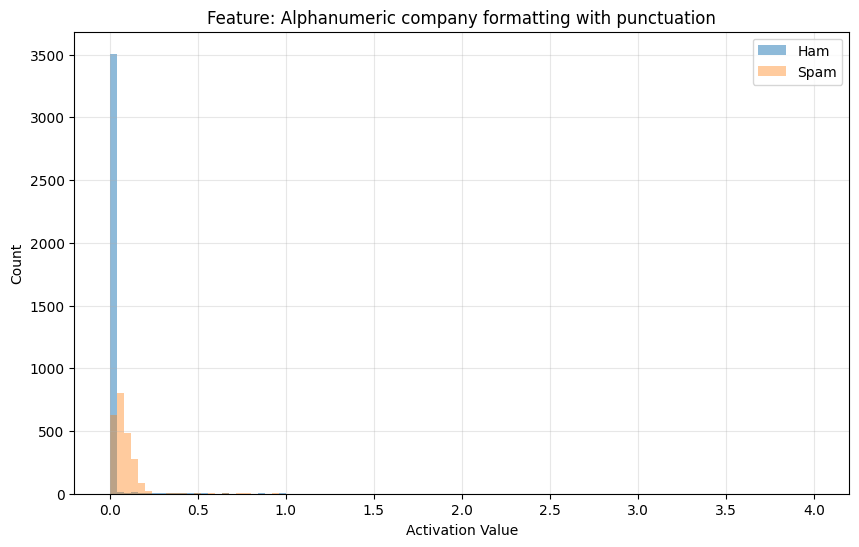

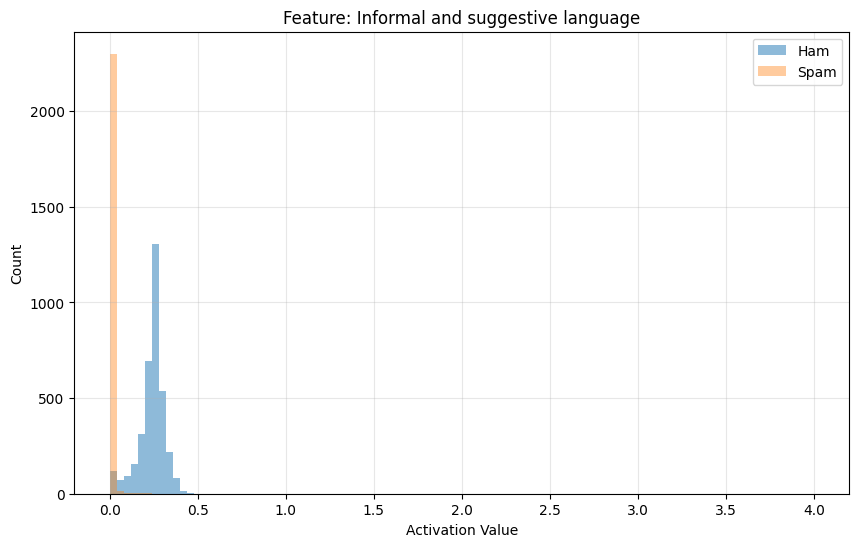

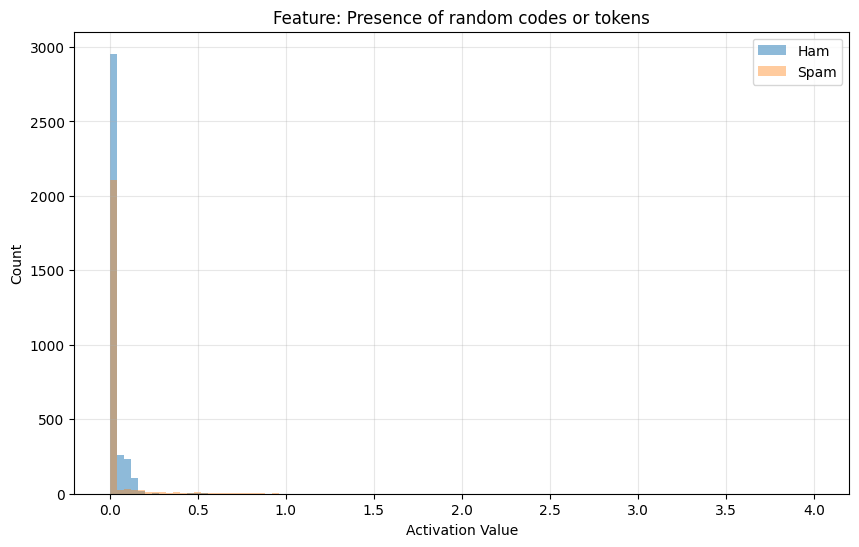

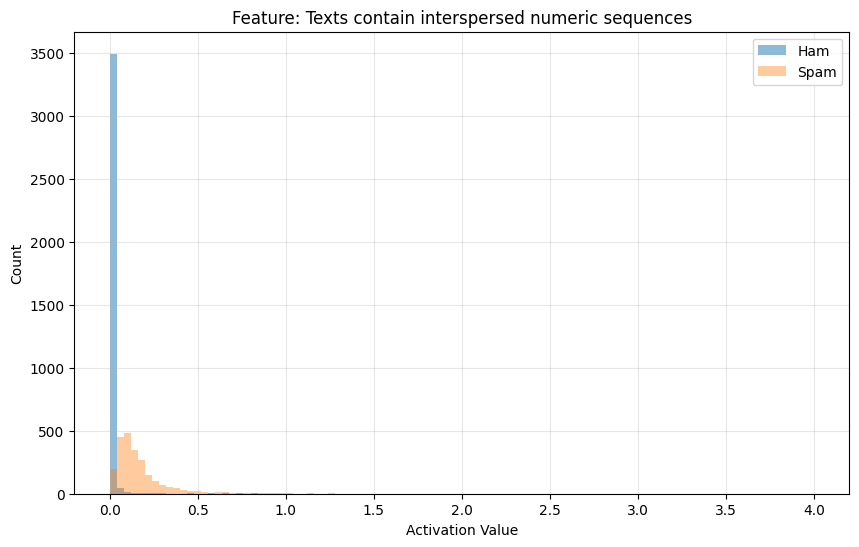

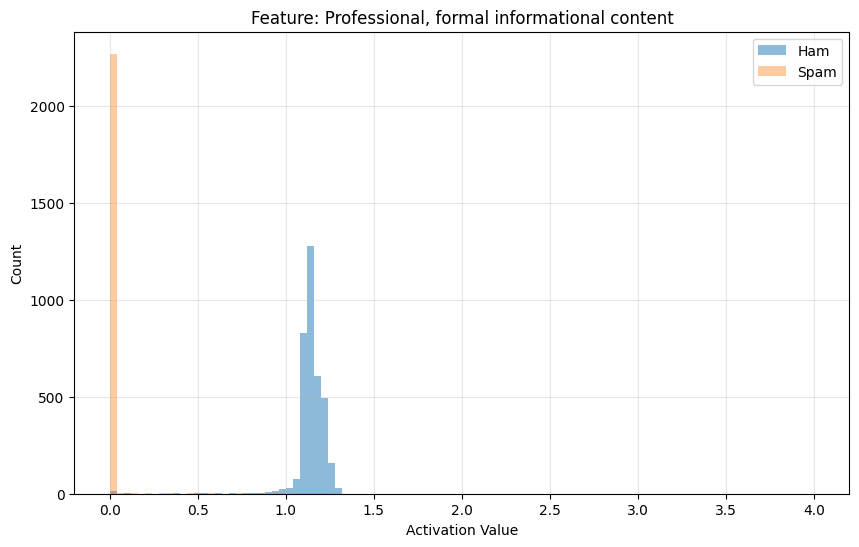

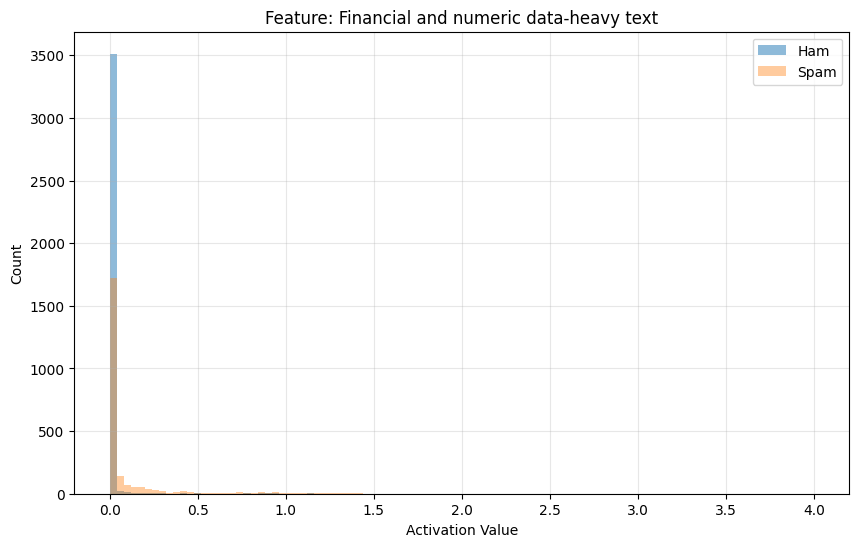

In [49]:
for result in main_results:
    idx = result['combo'][0]
    feature_idx = autointerp_feature_ids.index(idx)
    feature_name = autointerp_feature_labels[feature_idx]
    split_value = result['split_values']
    plot_feature_distribution(X_test, y_test, feature_idx, feature_name, split_value)